In [1]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from adjustText import adjust_text

#constantes
random_state = 42
plotColor = ['c','palegreen','salmon','plum','aquamarine', 'y','tan','peru']
#markers = ['+','o','*','^','v','>','<','-','#']
markers = ['P','H','*','^','v','>','<','D','s']

#set up
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# Create Data class which has load_data method
class Data:
    def __init__(self):
        print("Data object initiated")
    
    def Load_data(self,filepath,format='csv'):
        """ Read data from file and return data """
        if format == 'csv':
            return pd.read_csv(filepath, encoding = 'utf8', sep=",")
        elif format == 'xlsx':
            return pd.read_excel(filepath)

In [3]:
data_file = 'RetirosFCLPaT.csv'
extension = 'csv'

data = Data()
df_raw = data.Load_data(data_file, extension)
df_raw.columns =['Afiliado','Periodo','Edad','RangoEdad','Genero','EstadoCivil',\
                 'EstCiv','HayRetiro','TipoRetiro','Salario','RangoSalario','SalarioPromedioRetorno',\
                 'RangoSalarioRetorno','Reduccion','%Reduccion','TuvoReduccion','FechaRetorno','FechaUltimoAporte'\
                 ,'HayAportes','Pensionado','Difunto','MesDesempleadoAntesRetorno','MesesDesempleado',\
                 'MesesTrancurridos','Desempleado','EstuvoDesempleado','Sector','ActiviEconomica','DivisionEconomica',\
                'Provincia','Canton']


Data object initiated


In [4]:
# Crear Columna de brechas
# Convertir en fecha la columnas Periodo, FechaRetorno y FechaUltimo Aporte
df_work = df_raw.copy()

df_work['Periodo'] = pd.to_datetime(df_work['Periodo'])
df_work['FechaRetorno'] = pd.to_datetime(df_work['FechaRetorno'])
df_work['FechaUltimoAporte'] = pd.to_datetime(df_work['FechaUltimoAporte'])
df_work['Periodo'] = pd.to_datetime(df_work['Periodo']).apply(lambda x:x.strftime('%Y/%m'))
#FechaCorte = '2021-03-31'
#df_work['DiferenciaBrechas'] = df_work['RangoSalario'] - df_work['RangoSalarioRetorno']
#df_work['DiferenciaBrechas'] = np.where(df_work['DiferenciaBrechas']<=0, 0, df_work['DiferenciaBrechas'])

# Para que solo consideresi existen y las interprete como binarias
df_work['DiferenciaBrechas'] = np.where(df_work['RangoSalario'] - df_work['RangoSalarioRetorno'] > 0,1,0) #np.select(condicion,values,default=0)
df_work['MesDesempleadoAntesRetorno'] = np.where(df_work['MesDesempleadoAntesRetorno'] > 0, 1, 0)
df_work['MesesDesempleado'] = np.where(df_work['MesesDesempleado'] > 0, 1, 0)
df_work['HayAportes'] = np.where(df_work['HayAportes'] > 0, 1, 0)
# Hay slo 30 registros que genero en X, mejor cambiarlos con la mayoria para no afectar por un elemento más el modelo.
df_work['Genero']= df_work['Genero'].replace(['X'],['M'])                             

df_work.head().T                           

,0,1,2,3,4
Afiliado,27,217,217,227,286
Periodo,2020/05,2021/03,2021/03,2020/08,2021/02
Edad,85,77,77,76,75
RangoEdad,Entre59y100,Entre59y100,Entre59y100,Entre59y100,Entre59y100
Genero,F,M,M,F,F
EstadoCivil,4,1,1,2,1
EstCiv,VIUDO,SOLT,SOLT,CASAD,SOLT
HayRetiro,1,1,1,1,1
TipoRetiro,E,E,E,E,E
Salario,245133,0,0,0,0


In [5]:
# Identificar valor duplicados
valoresduplicados = df_work.duplicated()
print(valoresduplicados.sum())
df_work[valoresduplicados]

52026


,Afiliado,Periodo,Edad,RangoEdad,Genero,EstadoCivil,EstCiv,HayRetiro,TipoRetiro,Salario,...,MesesDesempleado,MesesTrancurridos,Desempleado,EstuvoDesempleado,Sector,ActiviEconomica,DivisionEconomica,Provincia,Canton,DiferenciaBrechas
2,217,2021/03,77,Entre59y100,M,1,SOLT,1,E,0.0,...,1,1,0,0,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
30,981,2020/09,67,Entre59y100,F,1,SOLT,1,E,0.0,...,1,7,0,0,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
40,1176,2020/03,72,Entre59y100,F,3,DIVOR,1,E,0.0,...,1,13,0,0,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
41,1176,2020/03,72,Entre59y100,F,3,DIVOR,1,E,0.0,...,1,13,0,0,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
42,1176,2020/03,72,Entre59y100,F,3,DIVOR,1,E,0.0,...,1,13,0,0,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
923801,5723630,2020/11,58,Entre45y59,F,1,SOLT,1,E,0.0,...,1,5,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
923884,5730221,2021/02,27,Menor31,F,1,SOLT,1,E,0.0,...,1,2,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
923935,5735213,2021/01,36,Entre31y45,F,0,DESC,1,E,0.0,...,1,3,1,1,SECTOR PRIVADO,"ACTIVIDADES INMOBILIARIAS, EMPRESARIALES Y DE ...",ACTIVIDADES DE INVESTIGACIÓN Y SEGURIDAD,LIMON,POCOCI,1
923961,5738221,2020/10,59,Entre45y59,F,2,CASAD,1,E,0.0,...,1,6,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1


In [6]:
X = df_work.copy()

X.drop(['Afiliado','EstadoCivil','FechaRetorno','FechaUltimoAporte'], axis=1, inplace=True)
X.drop(['Reduccion', '%Reduccion','MesesTrancurridos'], axis=1, inplace=True)

df_work= X.copy()

In [7]:
df_work.isnull().any()

Periodo                       False
Edad                          False
RangoEdad                     False
Genero                        False
EstCiv                        False
HayRetiro                     False
TipoRetiro                    False
Salario                       False
RangoSalario                  False
SalarioPromedioRetorno        False
RangoSalarioRetorno           False
TuvoReduccion                 False
HayAportes                    False
Pensionado                    False
Difunto                       False
MesDesempleadoAntesRetorno    False
MesesDesempleado              False
Desempleado                   False
EstuvoDesempleado             False
Sector                        False
ActiviEconomica               False
DivisionEconomica             False
Provincia                      True
Canton                         True
DiferenciaBrechas             False
dtype: bool

In [8]:
# Se descartan filas y columnas innecesarias
X = df_work.copy()

# Limpiamos datos de salarios y edad extraños
# Se borran 18 registros con edades > 100 se asumen como anomalias.
X = X.drop(X[X['Edad']>100].index)

# Se borra salario menor que 0
X = X.drop(X[X['Salario']<0].index)
X = X.drop(X[X['SalarioPromedioRetorno']<0].index)
X = X.reset_index(drop=True)

df_work = X.copy()
#df_work.head(10)
## Siguen quedando salario perdidos

In [9]:
def detectar_outlier(data):
    # find q1 and q3 values
    q1, q3 = np.percentile(sorted(data), [1, 99])  #Antes 25 y 75
 
    # compute IRQ
    iqr = q3 - q1
 
    # find lower and upper bounds
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
 
    outliers = [x for x in data if x <= lower_bound or x >= upper_bound]
    return outliers

In [10]:
df_raw1 = df_work.copy()
monto_cols1=["Salario","SalarioPromedioRetorno"]
#print('Antes ',df_raw1.shape)

for j in monto_cols1:
    outliers = detectar_outlier(df_raw1[j])
    #print(outliers)
    for i in range(0,len(df_raw1)):
        if df_raw1[j][i] in outliers: ##== -200:
            #print(i,j)
            df_raw1[j][i] = -1
            #print(df_raw1[j][i],' contra ',df_raw1[j],' col ', j)
            #df_raw1.drop((df_raw1[df_raw1[j]==df_raw1[j][i]].index))
            #df_raw1[j != df_raw1[j][i]]
            #df_raw1.drop(df_raw1.index[i])

df_raw1 = df_raw1.drop(df_raw1[df_raw1['Salario']<0].index)
df_raw1 = df_raw1.drop(df_raw1[df_raw1['SalarioPromedioRetorno']<0].index)
df_raw1.reset_index(drop=True, inplace=True)


<ipython-input-10-c8ef00453f06>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_raw1[j][i] = -1


In [11]:
df_work = df_raw1.copy()
df_work.head().T

,0,1,2,3,4
Periodo,2020/05,2021/03,2021/03,2020/08,2021/02
Edad,85,77,77,76,75
RangoEdad,Entre59y100,Entre59y100,Entre59y100,Entre59y100,Entre59y100
Genero,F,M,M,F,F
EstCiv,VIUDO,SOLT,SOLT,CASAD,SOLT
HayRetiro,1,1,1,1,1
TipoRetiro,E,E,E,E,E
Salario,245133,0,0,0,0
RangoSalario,1,1,1,1,1
SalarioPromedioRetorno,2.4319e+06,0,0,0,0


In [12]:
df_work.isnull().any()

Periodo                       False
Edad                          False
RangoEdad                     False
Genero                        False
EstCiv                        False
HayRetiro                     False
TipoRetiro                    False
Salario                       False
RangoSalario                  False
SalarioPromedioRetorno        False
RangoSalarioRetorno           False
TuvoReduccion                 False
HayAportes                    False
Pensionado                    False
Difunto                       False
MesDesempleadoAntesRetorno    False
MesesDesempleado              False
Desempleado                   False
EstuvoDesempleado             False
Sector                        False
ActiviEconomica               False
DivisionEconomica             False
Provincia                      True
Canton                         True
DiferenciaBrechas             False
dtype: bool

In [13]:
df_work.fillna({'Provincia': 'DESCONOCIDA'}, inplace=True)
df_work.fillna({'Canton': 'DESCONOCIDO'}, inplace=True)

In [14]:
def Transforma_Renombra_Datos(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df_raw.copy()
    
    df_cal.rename(columns={'EstCiv':'EstadoCivil'
                       ,'DiferenciaBrechas':'Brecha'
                       ,'MesDesempleadoAntesRetorno':'InactivoPostRetiro'
                       ,'MesesDesempleado':'InactivoPostUltAporte'
                      }
              ,inplace=True)

    # Pasa a valor de texto
    df_cal['Edad'] = df_cal.Edad.astype(int)
    df_cal['RangoSalario'] = df_cal.RangoSalario.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    df_cal['RangoSalarioRetorno'] = df_cal.RangoSalarioRetorno.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    df_cal['TuvoReduccion'] = df_cal.TuvoReduccion.map({1:'Si',0:'No'})
    df_cal['TipoRetiro'] = df_cal.TipoRetiro.map({'E':'Extinción','S':'Suspensión','R':'Reducción'})
    df_cal['Pensionado'] = df_cal.Pensionado.map({1:'Si',0:'No'})
    df_cal['Desempleado'] = df_cal.Desempleado.map({1:'Si',0:'No'})
    df_cal['Difunto'] = df_cal.Difunto.map({1:'Si',0:'No'})
    df_cal['EstuvoDesempleado'] = df_cal.EstuvoDesempleado.map({1:'Si',0:'No'})


    '''
    df_cal['Partner'] = df_cal.Partner.map({'Yes':1,'No':0})
    df_cal['Dependents'] = df_cal.Dependents.map({'Yes':1,'No':0})

    df_cal['PhoneService'] = df_cal.PhoneService.map({'Yes':1,'No':0})
    df_cal['MultipleLines'] = df_cal.MultipleLines.map({'Yes':1,'No':0,'No phone service':0})
    df_cal['InternetService'] = df_cal.InternetServiceType.map({'DSL':1,'Fiber optic':1,'No':0})
    df_cal['OnlineSecurity'] = df_cal.OnlineSecurity.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['OnlineBackup'] = df_cal.OnlineBackup.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['DeviceProtection'] = df_cal.DeviceProtection.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['TechSupport'] = df_cal.TechSupport.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingTV'] = df_cal.StreamingTV.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['StreamingMovies'] = df_cal.StreamingMovies.map({'Yes':1,'No':0,'No internet service':0})
    df_cal['PaperlessBilling'] = df_cal.PaperlessBilling.map({'Yes':1,'No':0})
    df_cal['Churn'] = df_cal.Churn.map({'Yes':1,'No':0})
    
    # Data mining
    df_cal['IsContracted'] = df_cal.ContractType.map({'One year':1,'Two year':1,'Month-to-month':0})
    
    # Data transformation
    
    # Converting TotalCharges into Numeric, but some of the records are empty, so first we need to deal with them.
    df_cal.loc[df_cal['TotalCharges']==' ','TotalCharges'] = np.nan
    
    # First we convert TotalCharges to float and then replace with tenure * monthly charges
    df_cal['TotalCharges'] = df_cal['TotalCharges'].astype('float64')
    df_cal.loc[df_cal['TotalCharges'].isnull()==True,'TotalCharges'] = df_cal['MonthlyCharges'] * df_cal['Tenure']
    '''

    return df_cal

In [15]:
df_cal = Transforma_Renombra_Datos(df_work)

df_cal.head()

,Periodo,Edad,RangoEdad,Genero,EstadoCivil,HayRetiro,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,...,InactivoPostRetiro,InactivoPostUltAporte,Desempleado,EstuvoDesempleado,Sector,ActiviEconomica,DivisionEconomica,Provincia,Canton,Brecha
0,2020/05,85,Entre59y100,F,VIUDO,1,Extinción,245133.333,<=Minimo,2431900.0,...,1,1,No,No,SECTOR PRIVADO,INTERMEDIACION FINANCIERA,OTROS DE TIPOS DE INTEMEDIACIÓN FINANCIERA NCP,SAN JOSE,CENTRAL,0
1,2021/03,77,Entre59y100,M,SOLT,1,Extinción,0.000,<=Minimo,0.0,...,1,1,No,No,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
2,2021/03,77,Entre59y100,M,SOLT,1,Extinción,0.000,<=Minimo,0.0,...,1,1,No,No,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
3,2020/08,76,Entre59y100,F,CASAD,1,Extinción,0.000,<=Minimo,0.0,...,1,1,No,No,SECTOR PUBLICO,"ADMINISTRACION PUBLICA Y DEFENSA, PLANES DE SE...",ACTIVIDADES DE PLANES DE SEGURIDAD SOCIAL DE A...,SAN JOSE,CENTRAL,1
4,2021/02,75,Entre59y100,F,SOLT,1,Extinción,0.000,<=Minimo,0.0,...,1,1,No,No,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1


In [16]:
# Se descartan la filas de pensionados ya que para el estudio no se requieren
X = df_cal.copy()
X = X.drop(X[X['Pensionado']=='Si'].index)
X = X.drop(X[X['Difunto']=='Si'].index)
X.drop(['Pensionado'], axis=1, inplace=True)
X.drop(['Difunto'], axis=1, inplace=True)
X = X.reset_index(drop=True)
df_cal= X.copy()
X = df_work.copy()
X = X.drop(X[X['Pensionado']==1].index)
X = X.drop(X[X['Difunto']==1].index)
X.drop(['Pensionado'], axis=1, inplace=True)
X.drop(['Difunto'], axis=1, inplace=True)
X = X.reset_index(drop=True)
df_work = X.copy()
binary_cols = ["TuvoReduccion","EstuvoDesempleado"]
binary_cols = binary_cols + [ 'HayAportes','Brecha','InactivoPostUltAporte','InactivoPostRetiro']

In [17]:
df_cal.head().T

,0,1,2,3,4
Periodo,2020/08,2020/11,2020/11,2020/11,2020/05
Edad,68,66,66,66,65
RangoEdad,Entre59y100,Entre59y100,Entre59y100,Entre59y100,Entre59y100
Genero,F,F,F,F,F
EstadoCivil,CASAD,SOLT,SOLT,SOLT,VIUDO
HayRetiro,1,1,1,1,1
TipoRetiro,Extinción,Extinción,Extinción,Extinción,Extinción
Salario,0,0,0,0,0
RangoSalario,<=Minimo,<=Minimo,<=Minimo,<=Minimo,<=Minimo
SalarioPromedioRetorno,0,0,0,0,0


In [18]:
def One_hot_encoding(df,feature):
    """ Apply one hot encoding to given features """
    return pd.concat([df
                      , pd.get_dummies(df[feature])]
                     , axis = 1)

def Normalize_feature(feature):
    """ Return normalized features """
    return prepro.StandardScaler().fit_transform(feature)

def Normalize_df(data, cols):
    """ Normalize features """
    for col in cols:
        data[col] = Normalize_feature(data[[col]])

def CambiaColumnas(df_raw):
    """ Rename column names and transformed into proper format and return dataframe """
    df_cal = df_raw.copy()
    
    # Pasa a valor de texto
    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder
    label_encoder=LabelEncoder()
    #df_cal.loc[:,'RangoSalario'] = LabelEncoder().fit_transform(df_cal.loc[:,'RangoSalario'])
    #df_cal.loc[:,'RangoSalarioRetorno'] = LabelEncoder().fit_transform(df_cal.loc[:,'RangoSalarioRetorno'])
    #df_cal['RangoSalario'] = df_cal.RangoSalario.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    #df_cal['RangoSalarioRetorno'] = df_cal.RangoSalarioRetorno.map({0:'No',1:'<=Minimo',2:'0.32-0.85',3:'0.85-1.23',4:'1.23-2.17',5:'2.17-4.33',6:'>4.33'})
    #df_cal['TipoRetiro'] = df_cal.TipoRetiro.map({'E':'Extinción','S':'Suspensión','R':'Reducción'})
    #df_cal.loc[:,'TipoRetiro'] = LabelEncoder().fit_transform(df_cal.loc[:,'TipoRetiro'])
    df_cal['TuvoReduccion'] = df_cal.TuvoReduccion.map({'Si':1,'No':0})    
    df_cal['Desempleado'] = df_cal.Desempleado.map({'Si':1,'No':0})
    df_cal['EstuvoDesempleado'] = df_cal.EstuvoDesempleado.map({'Si':1,'No':0})
    #df_cal = One_hot_encoding(df_cal, ['TipoRetiro','RangoEdad','EstadoCivil','RangoSalario','RangoSalarioRetorno','Genero'])
    #df_cal = Normalize_df(df_cal, ['Salario','SalarioPromedioRetorno','Edad'])
    #df_cal.head().T
    print(1)
    df_cal.drop(['Periodo','HayRetiro'], axis = 1, inplace = True)
    
    return df_cal  

In [19]:
#df_temp = CambiaColumnas(df_cal)
#Cambiar a estandarizado
from sklearn.preprocessing import StandardScaler
col_names = ['Salario','SalarioPromedioRetorno','Edad']
features = df_cal[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
scaled_features = pd.DataFrame(features, columns = col_names)
scaled_features.head()

,Salario,SalarioPromedioRetorno,Edad
0,-0.632024,-0.451412,2.909892
1,-0.632024,-0.451412,2.719910
2,-0.632024,-0.451412,2.719910
3,-0.632024,-0.451412,2.719910
4,-0.632024,-0.451412,2.624919


In [20]:
#Se Excluyen los rangos porque tienen relación con otras variables
#columnas = df_cal[['TipoRetiro','RangoEdad','EstadoCivil','RangoSalario','RangoSalarioRetorno','Genero']]

columnas = df_cal[['TipoRetiro','EstadoCivil','Genero','Sector','ActiviEconomica','DivisionEconomica','Provincia','Canton']]
df_temp = scaled_features.join(columnas)

df_temp = pd.get_dummies(df_temp, prefix=None, prefix_sep='_', dummy_na=False, columns=None, sparse=False, drop_first=False, dtype=None)

df_temp = df_temp.drop(['Genero_M','TipoRetiro_Suspensión','EstadoCivil_DESC'],axis=1)

df_temp.head().T

,0,1,2,3,4
Salario,-0.632024,-0.632024,-0.632024,-0.632024,-0.632024
SalarioPromedioRetorno,-0.451412,-0.451412,-0.451412,-0.451412,-0.451412
Edad,2.909892,2.719910,2.719910,2.719910,2.624919
TipoRetiro_Extinción,1.000000,1.000000,1.000000,1.000000,1.000000
TipoRetiro_Reducción,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
Canton_TILARAN,0.000000,0.000000,0.000000,0.000000,0.000000
Canton_TURRIALBA,0.000000,0.000000,0.000000,0.000000,0.000000
Canton_TURRUBARES,0.000000,0.000000,0.000000,0.000000,0.000000
Canton_UPALA,0.000000,0.000000,0.000000,0.000000,0.000000


In [21]:
df_cal['TuvoReduccion'] = df_cal.TuvoReduccion.map({'Si':1,'No':0})    
df_cal['Desempleado'] = df_cal.Desempleado.map({'Si':1,'No':0})
df_cal['EstuvoDesempleado'] = df_cal.EstuvoDesempleado.map({'Si':1,'No':0})

In [22]:
# No se emcluyen porque son las objetivo
#otrascolumnas = df_cal[['Desempleado', 'EstuvoDesempleado']]
#df_temp = df_temp.join(otrascolumnas)
#df_temp.head().T
df_cal.head().T

,0,1,2,3,4
Periodo,2020/08,2020/11,2020/11,2020/11,2020/05
Edad,68,66,66,66,65
RangoEdad,Entre59y100,Entre59y100,Entre59y100,Entre59y100,Entre59y100
Genero,F,F,F,F,F
EstadoCivil,CASAD,SOLT,SOLT,SOLT,VIUDO
HayRetiro,1,1,1,1,1
TipoRetiro,Extinción,Extinción,Extinción,Extinción,Extinción
Salario,0,0,0,0,0
RangoSalario,<=Minimo,<=Minimo,<=Minimo,<=Minimo,<=Minimo
SalarioPromedioRetorno,0,0,0,0,0


Text(0, 0.5, 'Inertia')

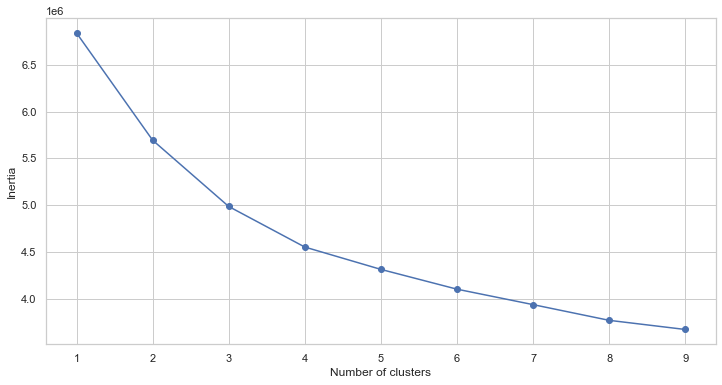

In [23]:
SSE = []

for cluster in range(1,10):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(df_temp)
    SSE.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,10), 'SSE':SSE})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['SSE'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

In [24]:
# First, build a model with 4 clusters

kmeans = KMeans(n_clusters = 4, init='k-means++')
kmeans.fit(df_temp)



KMeans(n_clusters=4)

In [25]:
from sklearn.metrics import silhouette_score
# Now, print the silhouette score of this model

print(silhouette_score(df_temp, kmeans.labels_, metric='euclidean'))

0.20042997264380277


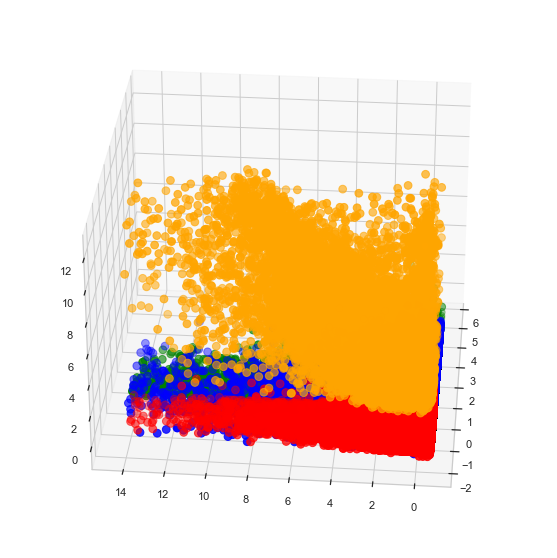

In [26]:
from mpl_toolkits.mplot3d import Axes3D
clusters = kmeans.fit_predict(df_temp.iloc[:,1:])
df_temp["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_temp.Edad[df_temp.label == 0], df_temp["Salario"][df_temp.label == 0], df_temp["SalarioPromedioRetorno"][df_temp.label == 0], c='blue', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 1], df_temp["Salario"][df_temp.label == 1], df_temp["SalarioPromedioRetorno"][df_temp.label == 1], c='red', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 2], df_temp["Salario"][df_temp.label == 2], df_temp["SalarioPromedioRetorno"][df_temp.label == 2], c='green', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 3], df_temp["Salario"][df_temp.label == 3], df_temp["SalarioPromedioRetorno"][df_temp.label == 3], c='orange', s=60)
#ax.scatter(df_temp.Edad[df_temp.label == 4], df_temp["Salario"][df_temp.label == 4], df_temp["SalarioPromedioRetorno"][df_temp.label == 4], c='yellow', s=60)
ax.view_init(30, 185)
plt.show()

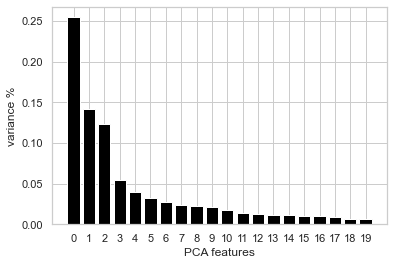

In [27]:
from sklearn.decomposition import PCA

pca = PCA(n_components=20)
principalComponents = pca.fit_transform(df_temp)

features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)

PCA_components = pd.DataFrame(principalComponents)


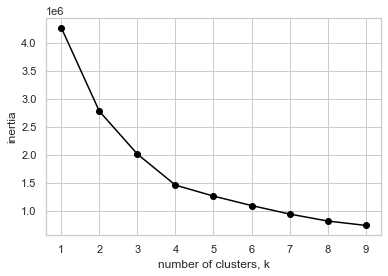

In [29]:
ks = range(1, 10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(PCA_components.iloc[:,:4]) # Numero de PCA que se usaran
    inertias.append(model.inertia_)

plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [32]:
# Aqui parece que el numero de clusters es 3
model = KMeans(n_clusters=4)
model.fit(PCA_components.iloc[:,:4]) # Numero de componentes

# silhouette score
print(silhouette_score(PCA_components.iloc[:,:4], model.labels_, metric='euclidean'))

0.4596792285310854


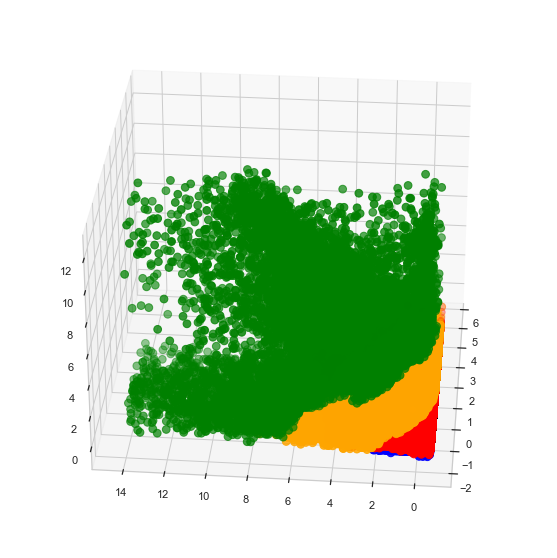

In [33]:
#from mpl_toolkits.mplot3d import Axes3D
clusters = model.fit_predict(PCA_components.iloc[:,:2])
df_temp["label"] = clusters
 
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_temp.Edad[df_temp.label == 0], df_temp["Salario"][df_temp.label == 0], df_temp["SalarioPromedioRetorno"][df_temp.label == 0], c='blue', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 1], df_temp["Salario"][df_temp.label == 1], df_temp["SalarioPromedioRetorno"][df_temp.label == 1], c='red', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 2], df_temp["Salario"][df_temp.label == 2], df_temp["SalarioPromedioRetorno"][df_temp.label == 2], c='green', s=60)
ax.scatter(df_temp.Edad[df_temp.label == 3], df_temp["Salario"][df_temp.label == 3], df_temp["SalarioPromedioRetorno"][df_temp.label == 3], c='orange', s=60)
#ax.scatter(df_temp.Edad[df_temp.label == 4], df_temp["Salario"][df_temp.label == 4], df_temp["SalarioPromedioRetorno"][df_temp.label == 4], c='yellow', s=60)
ax.view_init(30, 185)
plt.show()

In [34]:
X = df_work.copy()

X.drop(['Periodo','DiferenciaBrechas','Desempleado','EstuvoDesempleado','HayRetiro'], axis=1, inplace=True)

df_work= X.copy()

In [35]:


# map back clusters to dataframe

pred = model.predict(PCA_components.iloc[:,:2])
frame = pd.DataFrame(df_work)
frame['cluster'] = pred
frame.head(1000)

,Edad,RangoEdad,Genero,EstCiv,TipoRetiro,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,TuvoReduccion,HayAportes,MesDesempleadoAntesRetorno,MesesDesempleado,Sector,ActiviEconomica,DivisionEconomica,Provincia,Canton,cluster
0,68,Entre59y100,F,CASAD,E,0.000,1,0.000,0,0,0,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
1,66,Entre59y100,F,SOLT,E,0.000,1,0.000,0,0,0,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
2,66,Entre59y100,F,SOLT,E,0.000,1,0.000,0,0,0,1,1,SECTOR PRIVADO,ACTIVIDADES NO BIEN ESPECIFICADAS,ACTIVIDAD NO ESPECIFICADA,LIMON,CENTRAL,3
3,66,Entre59y100,F,SOLT,E,0.000,1,0.000,0,0,0,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
4,65,Entre59y100,F,VIUDO,E,0.000,1,0.000,0,0,0,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,61,Entre59y100,M,DIVOR,E,1399999.986,4,0.000,0,1,0,1,1,NO ENCONTRADO,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADA,NO ENCONTRADO,1
996,61,Entre59y100,M,DIVOR,E,366666.663,2,0.000,0,1,0,1,1,SECTOR PRIVADO,"COMERCIO AL POR MAYOR Y AL POR MENOR, REPARACI...",VENTA AL POR MAYOR DE ALIMENTOS BEBIDAS Y TABACO,SAN JOSE,GOICOECHEA,3
997,61,Entre59y100,M,DIVOR,E,1098566.667,3,1098566.667,3,0,0,1,1,SECTOR PUBLICO,"TRANSPORTE, ALMACENAMIENTO Y COMUNICACIONES",ACTIVIDADES POSTALES NACIONALES,SAN JOSE,CENTRAL,2
998,65,Entre59y100,M,CASAD,E,0.000,1,0.000,0,0,0,1,1,SECTOR PRIVADO,ENSEÑANZA,ENSEÑANZA SUPERIOR,SAN JOSE,CENTRAL,3


In [36]:
frame.head().T

,0,1,2,3,4
Edad,68,66,66,66,65
RangoEdad,Entre59y100,Entre59y100,Entre59y100,Entre59y100,Entre59y100
Genero,F,F,F,F,F
EstCiv,CASAD,SOLT,SOLT,SOLT,VIUDO
TipoRetiro,E,E,E,E,E
Salario,0,0,0,0,0
RangoSalario,1,1,1,1,1
SalarioPromedioRetorno,0,0,0,0,0
RangoSalarioRetorno,0,0,0,0,0
TuvoReduccion,0,0,0,0,0


In [37]:
avg_df = frame.groupby(['cluster'], as_index=False).mean()
avg_df

,cluster,Edad,Salario,RangoSalario,SalarioPromedioRetorno,RangoSalarioRetorno,TuvoReduccion,HayAportes,MesDesempleadoAntesRetorno,MesesDesempleado
0,0,32.432137,1.426257e+05,1.135960,4.611400e+04,0.245300,0.624770,0.139465,0.946681,0.879633
1,1,39.730853,1.272129e+05,1.170434,1.965937e+04,0.095008,0.391563,0.053209,0.951333,0.927065
2,2,41.905588,1.679472e+06,3.662993,1.270709e+06,3.120224,0.492727,0.694274,0.949269,0.493537
3,3,43.825243,4.348361e+05,1.740987,2.860873e+05,1.185487,0.558773,0.550785,0.941881,0.605953


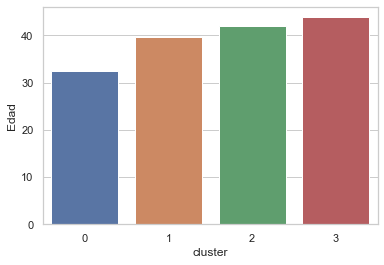

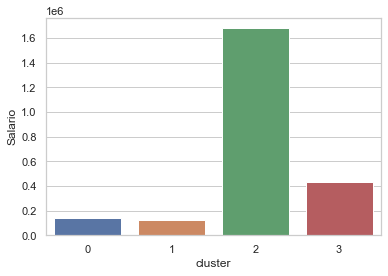

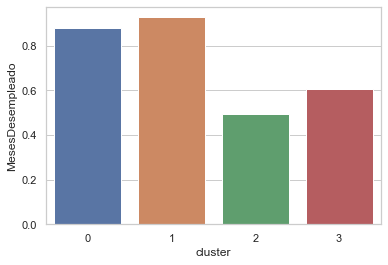

Genero
cluster Genero        
0       F       135187
        M       275641
1       F        81059
        M       142154
2       F         7776

In [38]:
sns.barplot(x='cluster',y='Edad',data=avg_df)
plt.show()
sns.barplot(x='cluster',y='Salario',data=avg_df)
plt.show()
sns.barplot(x='cluster',y='MesesDesempleado',data=avg_df)
plt.show()

df2 = pd.DataFrame(frame.groupby(['cluster','Genero'])['Genero'].count())
df2.head()

In [52]:
features = []
for column in df_clu.columns:
    if column != 'Desempleado':
        features.append(column)
X = df_clu[features]
y = df_clu['Desempleado']

In [53]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

KFold(), recibe como entrada el número k. Para cada par (conjunto de entrenamiento, conjunto de pruebas), puedo crear el modelo y calcular el error absoluto medio (MAE) tanto para el entrenamiento como para los conjuntos de pruebas. En este ejemplo específico exploto el KNeighborsClassifier().‎



In [54]:
kf = KFold(n_splits=4)
mae_train = []
mae_test = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = KNeighborsClassifier(n_neighbors=2) 
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))    

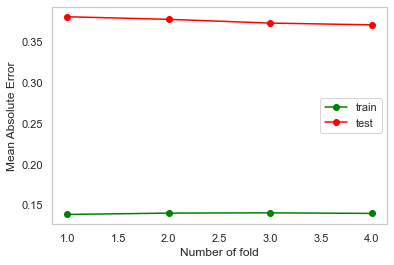

In [56]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()

In [61]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)
mae_train = []
mae_test = []
for train_index, test_index in skf.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = KNeighborsClassifier(n_neighbors=2) 
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred))  

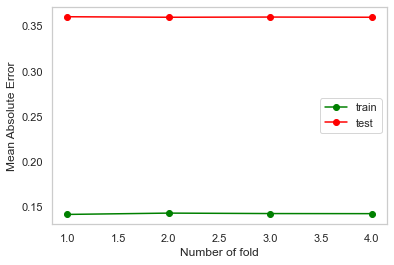

In [62]:
folds = range(1, skf.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()

El MAE para entrenamiento es demasiado pequeño, menos de 0.15 y para testing es por encima de 0.35. Esto es indcador de overfitting.

Vamos a reducir la complejidad de dataset

In [63]:
from sklearn.preprocessing import MinMaxScaler

In [64]:
for column in X.columns:
    feature = np.array(X[column]).reshape(-1,1)
    scaler = MinMaxScaler()
    scaler.fit(feature)
    feature_scaled = scaler.transform(feature)
    X[column] = feature_scaled.reshape(1,-1)[0]

<ipython-input-64-ce90d176bbe2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = feature_scaled.reshape(1,-1)[0]
<ipython-input-64-ce90d176bbe2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = feature_scaled.reshape(1,-1)[0]
<ipython-input-64-ce90d176bbe2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [65]:
#model = KNeighborsClassifier(n_neighbors=2)
#test_model(model, X,y)
kf = KFold(n_splits=4)
mae_train = []
mae_test = []
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = KNeighborsClassifier(n_neighbors=2) 
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    mae_train.append(mean_absolute_error(y_train, y_train_pred))
    mae_test.append(mean_absolute_error(y_test, y_test_pred)) 


KeyboardInterrupt: 

In [ ]:
folds = range(1, kf.get_n_splits() + 1)
plt.plot(folds, mae_train, 'o-', color='green', label='train')
plt.plot(folds, mae_test, 'o-', color='red', label='test')
plt.legend()
plt.grid()
plt.xlabel('Number of fold')
plt.ylabel('Mean Absolute Error')
plt.show()